# Project to create predictive model for football matches

## import the necessary libraries

In [20]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# STATISTICS
from statsmodels.graphics.gofplots import qqplot

#notebook settings
pd.set_option('display.max_columns', None)

#pipelines
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.compose import ColumnTransformer


## import dataset

In [21]:
data = pd.read_csv('data/football_data.csv')
data.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,Season
0,13/08/05,Aston Villa,Bolton,2.0,2.0,D,2.0,2.0,D,M Riley,3.0,13.0,2.0,6.0,14.0,16.0,7.0,8.0,0.0,2.0,0.0,0.0,2.30,3.25,3.00,2005
1,13/08/05,Everton,Man United,0.0,2.0,A,0.0,1.0,A,G Poll,10.0,12.0,5.0,5.0,15.0,14.0,8.0,6.0,3.0,1.0,0.0,0.0,5.00,3.40,1.72,2005
2,13/08/05,Fulham,Birmingham,0.0,0.0,D,0.0,0.0,D,R Styles,15.0,7.0,7.0,4.0,12.0,13.0,6.0,6.0,1.0,2.0,0.0,0.0,2.37,3.25,2.87,2005
3,13/08/05,Man City,West Brom,0.0,0.0,D,0.0,0.0,D,C Foy,15.0,13.0,8.0,3.0,13.0,11.0,3.0,6.0,2.0,3.0,0.0,0.0,1.72,3.40,5.00,2005
4,13/08/05,Middlesbrough,Liverpool,0.0,0.0,D,0.0,0.0,D,M Halsey,4.0,16.0,2.0,7.0,17.0,11.0,5.0,0.0,2.0,3.0,1.0,0.0,2.87,3.20,2.40,2005


# EDA (Exploratory Dataset Analysis)

## Dealing with missing values

In [22]:
# checking for null values
data.isnull().sum()

Date        1
HomeTeam    1
AwayTeam    1
FTHG        1
FTAG        1
FTR         1
HTHG        1
HTAG        1
HTR         1
Referee     1
HS          1
AS          1
HST         1
AST         1
HF          1
AF          1
HC          1
AC          1
HY          1
AY          1
HR          1
AR          1
B365H       1
B365D       1
B365A       1
Season      0
dtype: int64

In [23]:
# identify row with null values
data[data.isnull().any(axis=1)]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,Season
3800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014


In [24]:
# drop row with null values
class DropNullValues(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X = X.dropna().reset_index(drop=True)
        return X

## Dealing with duplicated values

In [25]:
# checking for duplicates
data.duplicated().sum()

0

## Uniques

In [26]:
data.nunique()

Date        1946
HomeTeam      43
AwayTeam      43
FTHG          10
FTAG          10
FTR            3
HTHG           6
HTAG           6
HTR            3
Referee       61
HS            40
AS            32
HST           24
AST           21
HF            29
AF            26
HC            21
AC            19
HY             8
AY            10
HR             3
AR             3
B365H        132
B365D         51
B365A        125
Season        19
dtype: int64

## Data type information

In [27]:
data.dtypes

Date         object
HomeTeam     object
AwayTeam     object
FTHG        float64
FTAG        float64
FTR          object
HTHG        float64
HTAG        float64
HTR          object
Referee      object
HS          float64
AS          float64
HST         float64
AST         float64
HF          float64
AF          float64
HC          float64
AC          float64
HY          float64
AY          float64
HR          float64
AR          float64
B365H       float64
B365D       float64
B365A       float64
Season        int64
dtype: object

In [28]:
# convert date column to datetime
class ConvertDateColumn(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X['Date'] = pd.to_datetime(X['Date'])
        return X

## Check for outliers

In [29]:
data.describe()

,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,Season
count,6960.000000,6960.000000,6960.000000,6960.000000,6960.000000,6960.000000,6960.000000,6960.000000,6960.000000,6960.000000,6960.000000,6960.000000,6960.000000,6960.000000,6960.000000,6960.000000,6960.000000,6960.000000,6960.000000,6961.000000
mean,1.534339,1.174569,0.687644,0.515948,13.762356,11.014080,5.898563,4.683333,10.956897,11.353017,5.983764,4.768391,1.482471,1.782759,0.060201,0.083190,2.823704,4.044931,4.873609,2013.663841
std,1.316426,1.161168,0.839201,0.732140,5.422605,4.741403,3.327037,2.798601,3.600009,3.754571,3.119021,2.750659,1.207931,1.286490,0.247353,0.286907,2.021530,1.216888,4.157051,5.289783
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.060000,2.500000,1.120000,2005.000000
25%,1.000000,0.000000,0.000000,0.000000,10.000000,8.000000,3.000000,3.000000,8.000000,9.000000,4.000000,3.000000,1.000000,1.000000,0.000000,0.000000,1.660000,3.300000,2.380000,2009.000000
50%,1.000000,1.000000,0.000000,0.000000,13.000000,10.000000,5.000000,4.000000,11.000000,11.000000,6.000000,4.000000,1.000000,2.000000,0.000000,0.000000,2.200000,3.600000,3.400000,2014.000000
75%,2.000000,2.000000,1.000000,1.000000,17.000000,14.000000,8.000000,6.000000,13.000000,14.000000,8.000000,6.000000,2.000000,3.000000,0.000000,0.000000,3.000000,4.200000,5.500000,2018.000000
max,9.000000,9.000000,5.000000,5.000000,43.000000,31.000000,24.000000,20.000000,33.000000,26.000000,20.000000,19.000000,7.000000,9.000000,2.000000,2.000000,23.000000,17.000000,41.000000,2023.000000


In [40]:
def plot_numerical_features(data):
    X_num = data.select_dtypes(exclude='object')
    
    for numerical_feature in X_num.columns:
        
        # Creating three subplots per numerical_feature
        fig, ax =plt.subplots(1,3,figsize=(15,3))
        
        # Histogram to get an overview of the distribution of each numerical_feature
        ax[0].set_title(f"Distribution of: {numerical_feature}")
        sns.histplot(data = X_num, x = numerical_feature, kde=True, ax = ax[0])
        
        # Boxplot to detect outliers
        ax[1].set_title(f"Boxplot of: {numerical_feature}")
        sns.boxplot(data = X_num, x = numerical_feature, ax=ax[1])
        
        # Analyzing whether a feature is normally distributed or not
        ax[2].set_title(f"Gaussianity of: {numerical_feature}")
        qqplot(X_num[numerical_feature],line='s',ax=ax[2]);

- The histogram with the estimated density shows us that *the distribution of the features if is quite skewed and non-Gaussian*
- The boxplot indicates some potential outliers.
- The QQ-plot is another proof that the distribution of the features is not Gaussian: Remember that the scatter dots of your signal should match the 
 (45-degree line) closely, if the signal is Gaussian distributed.

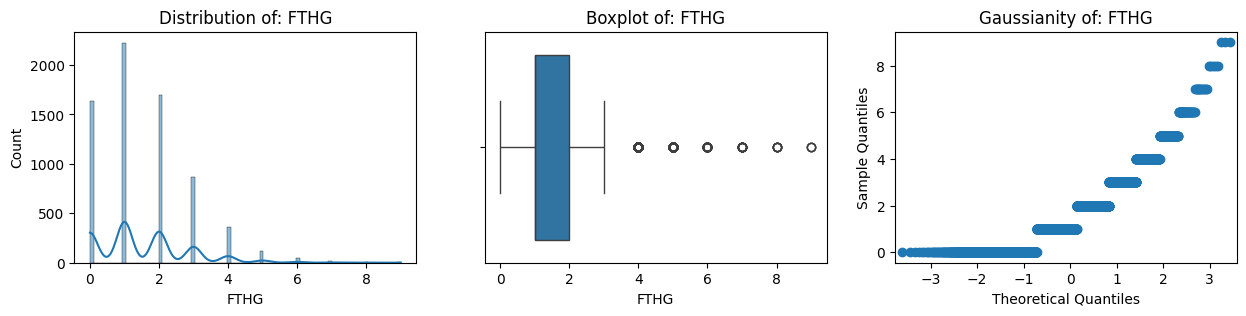

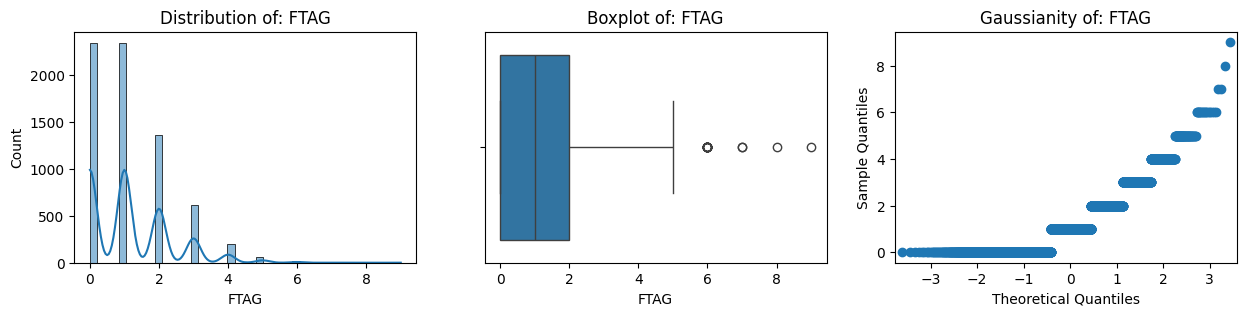

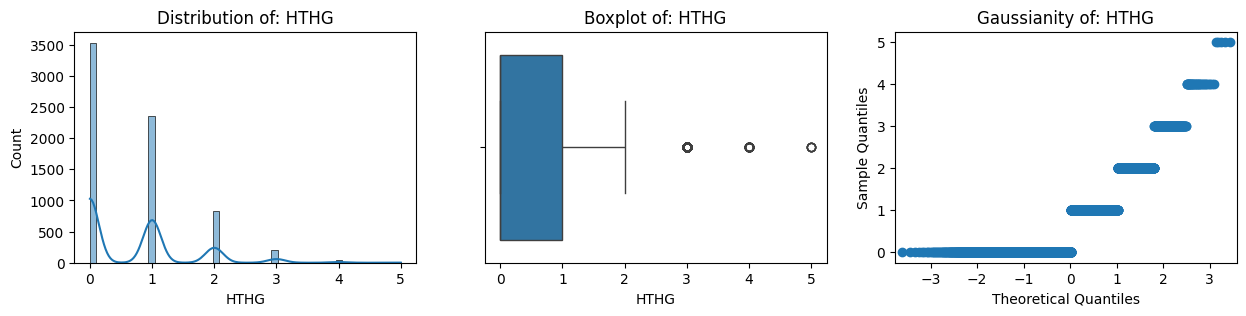

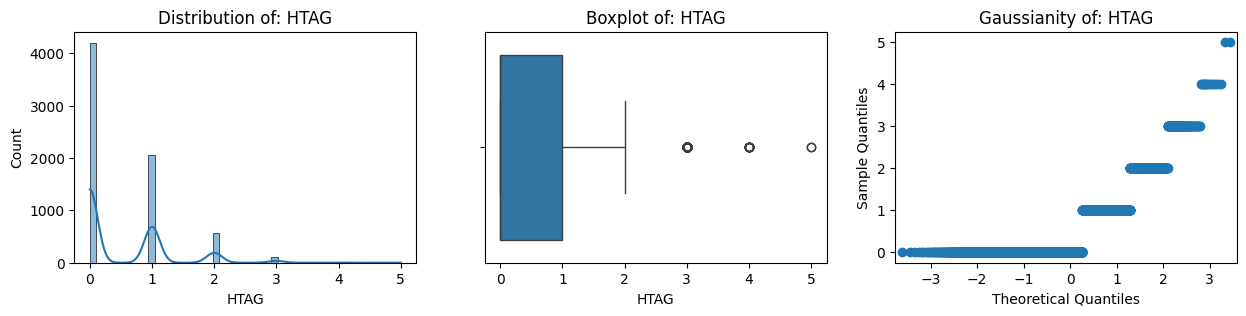

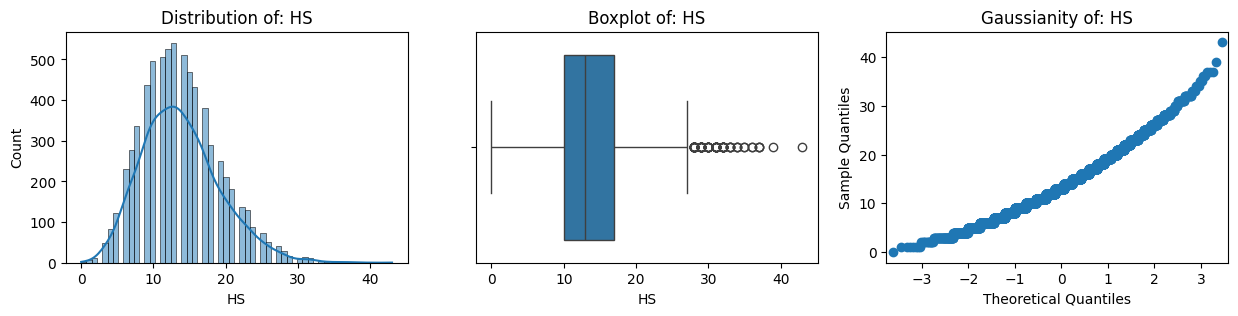

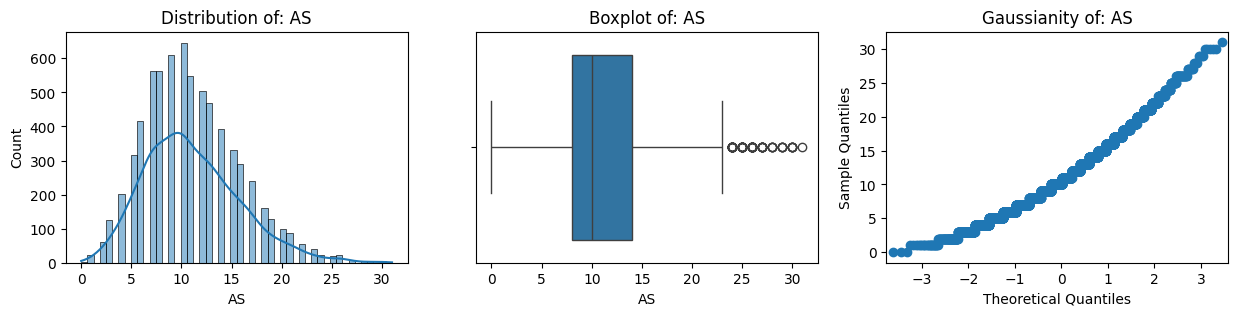

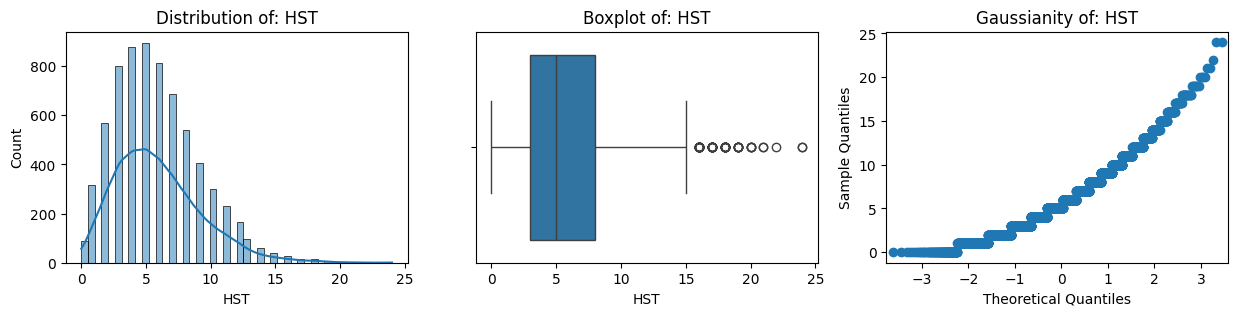

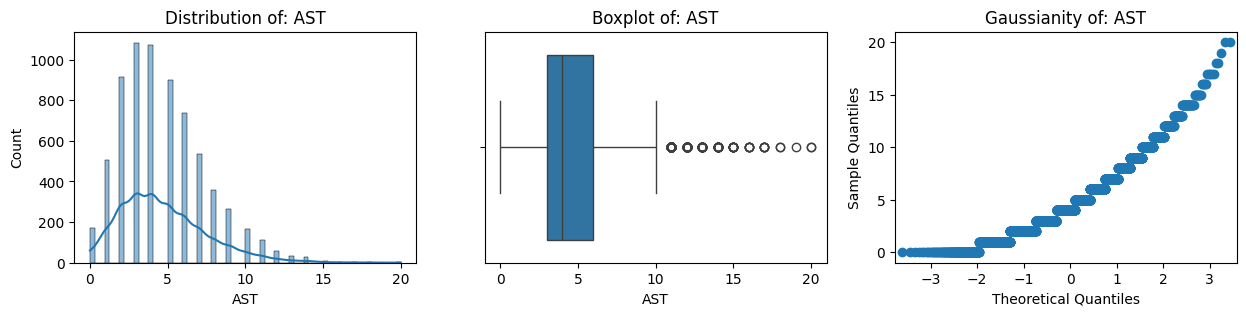

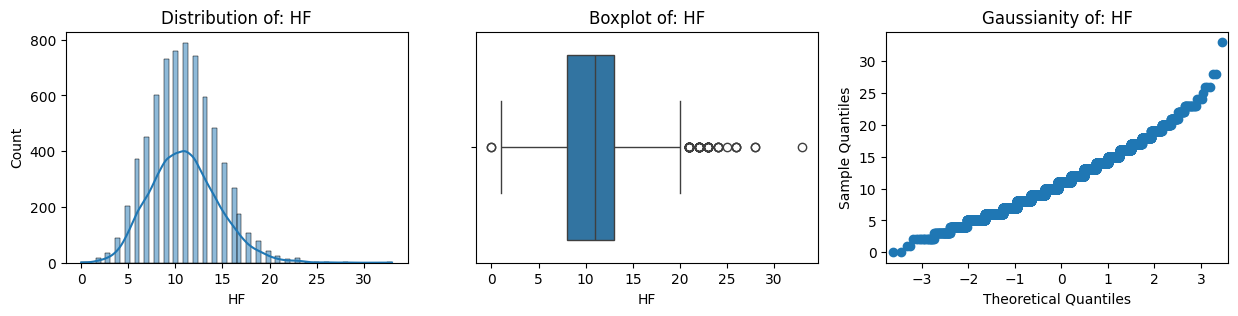

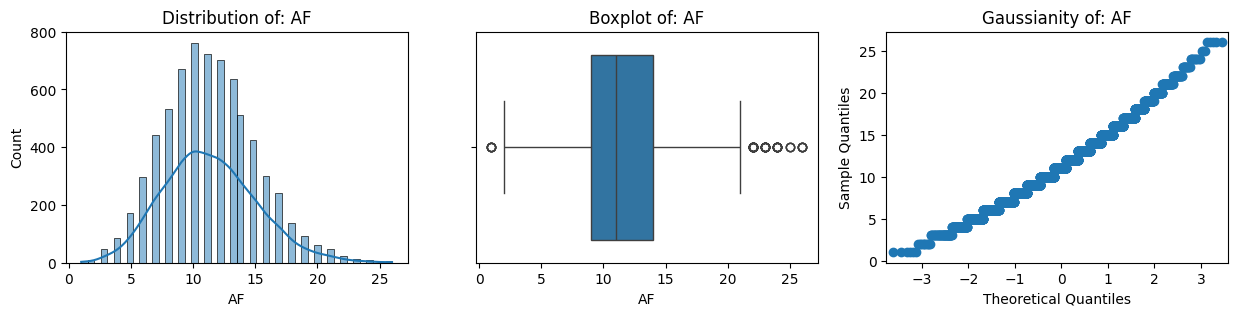

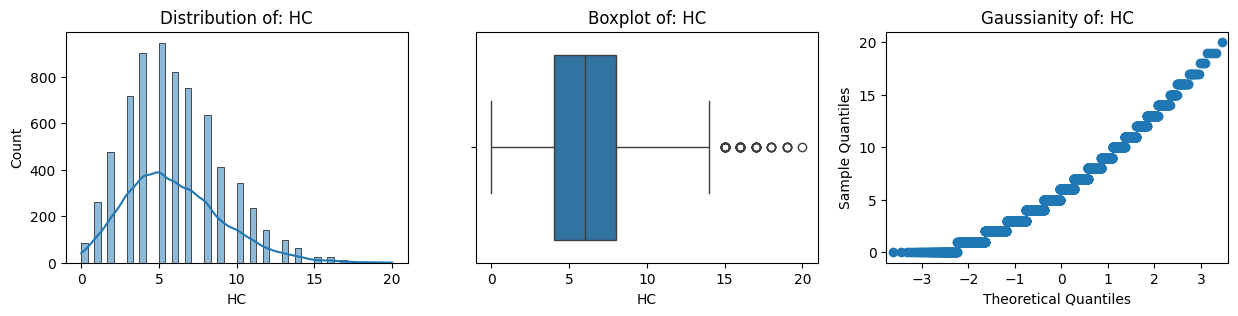

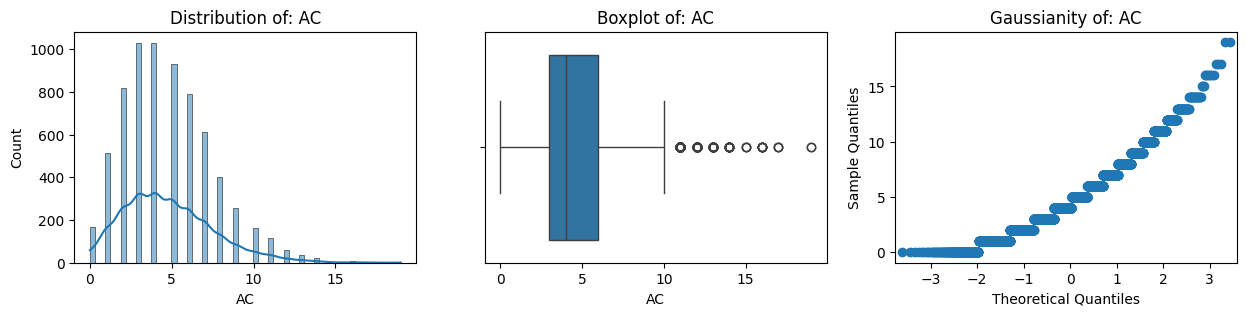

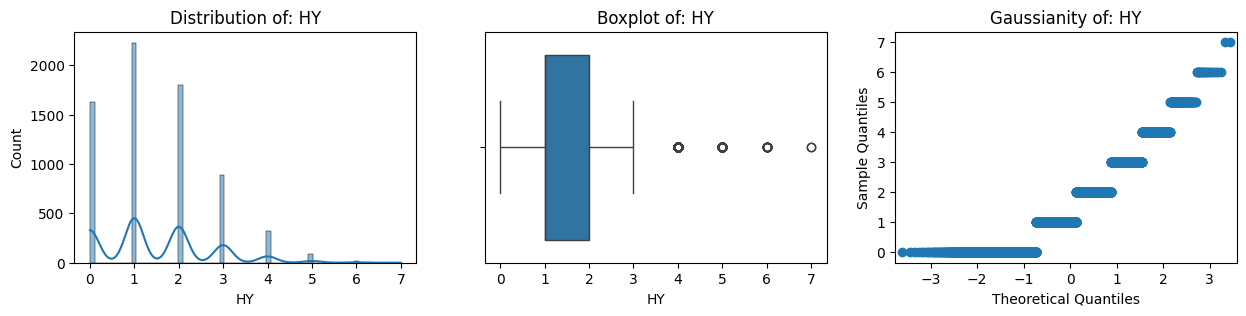

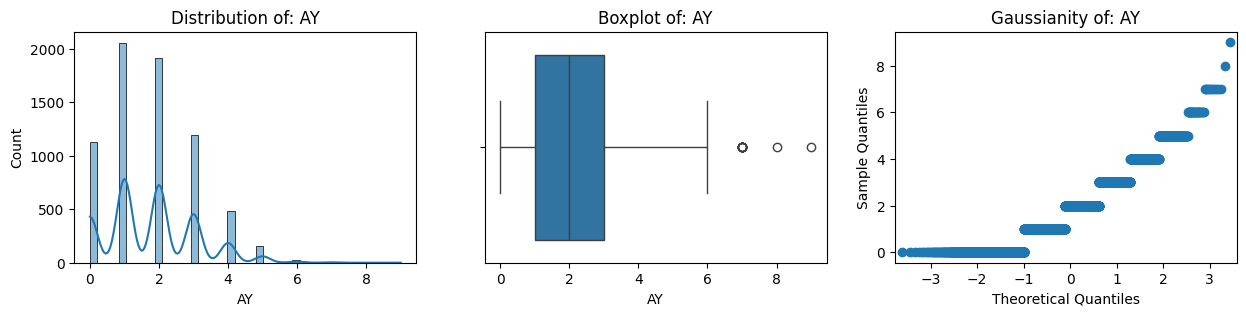

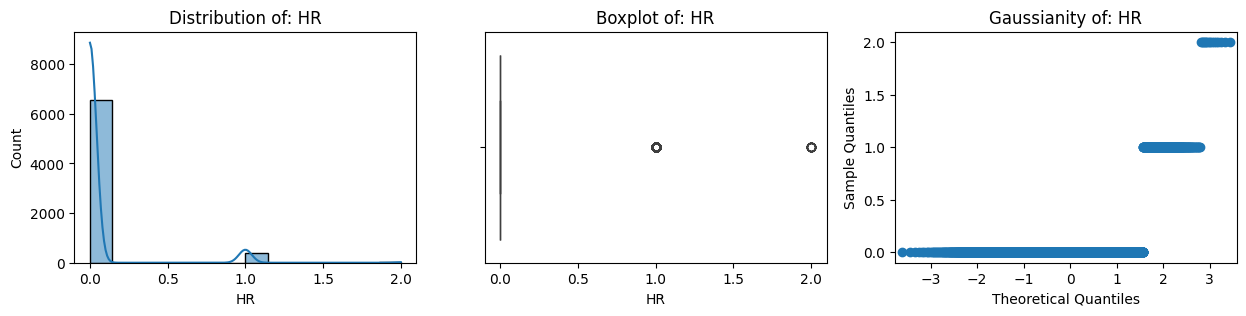

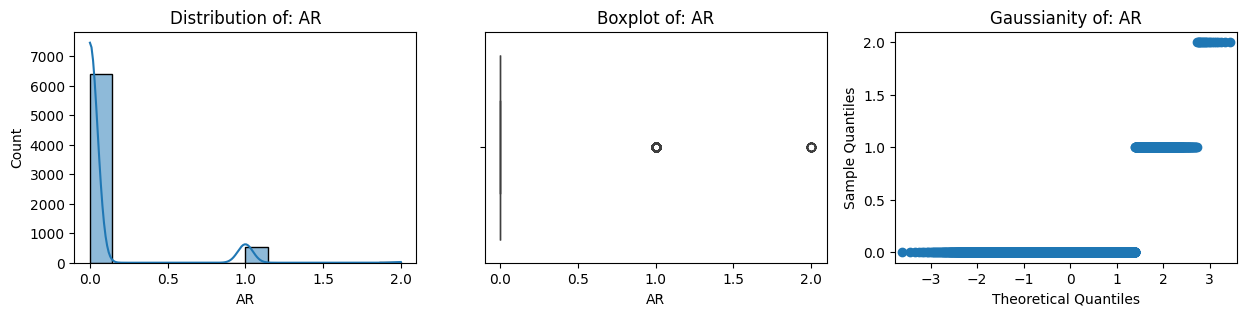

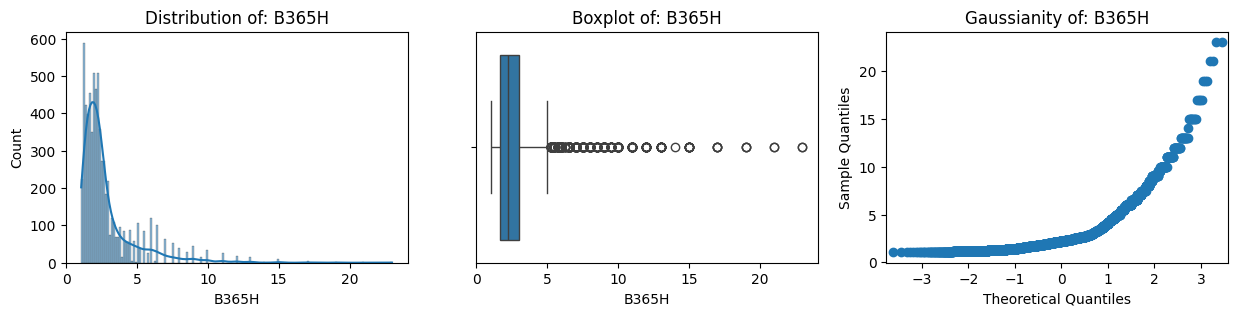

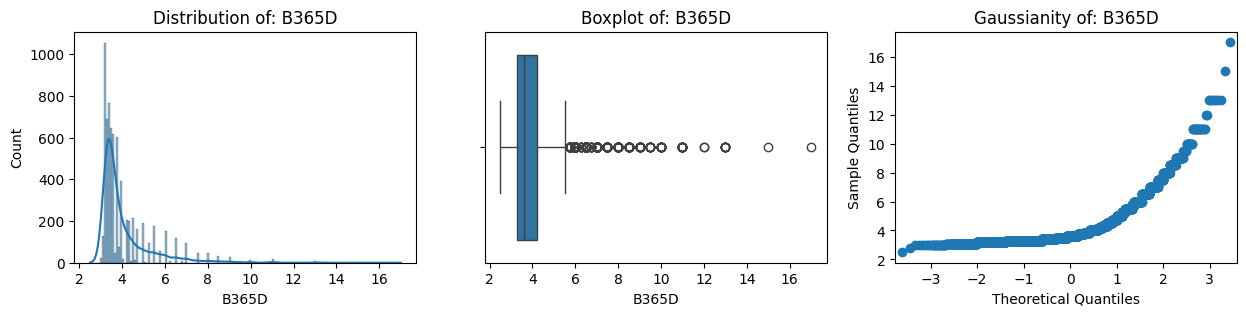

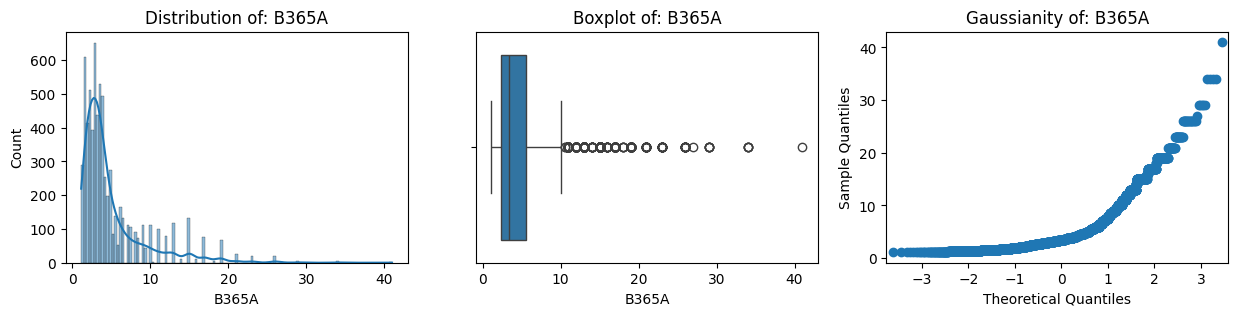

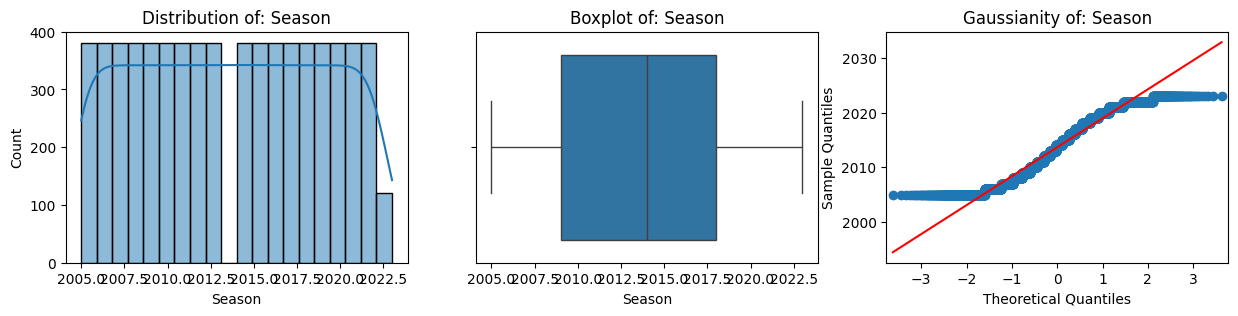

In [41]:
plot_numerical_features(data=data)

In [ ]:
# need to check best transformations for each feature
# test https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#plot-all-scaling-power-transformer-section